In [ ]:
# Install the library for splitting the dataset folder
!pip install split-folders -q

# Import all necessary libraries for the project
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2B0 # Importing our new model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import os
from sklearn.metrics import roc_curve, auc

# Verify TensorFlow version
print("Setup Complete. TensorFlow Version:", tf.__version__)

Setup Complete. TensorFlow Version: 2.19.0


In [ ]:
# --- Step 1: Set Kaggle API Credentials (no need to upload kaggle.json) ---
import os

# 🔑 Replace these with your own Kaggle username and key
os.environ["KAGGLE_USERNAME"] = "prajakta19052005"
os.environ["KAGGLE_KEY"] = "d4647593296b860330695959bf7b4a9d"

print("Kaggle API credentials set.")

# --- Step 2: Download and Unzip the Dataset ---
!rm -rf ./melanoma
!kaggle datasets download -d bhaveshmittal/melanoma-cancer-dataset -p ./melanoma --unzip -q
print("Melanoma Cancer Dataset downloaded and unzipped.")

Kaggle API credentials set.
Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset
License(s): CC0-1.0
Melanoma Cancer Dataset downloaded and unzipped.


In [ ]:
# 1) Quick check: count images in key folders
import os

def count_images(path):
    if not os.path.exists(path):
        return None
    return sum(1 for root, _, files in os.walk(path) for f in files if f.lower().endswith(('.jpg','.jpeg','.png')))

print("Counts (None means folder missing):")
print(" ./melanoma (downloaded) total images:", count_images("./melanoma"))
print(" all_images_combined/benign:", count_images("all_images_combined/benign"))
print(" all_images_combined/malignant:", count_images("all_images_combined/malignant"))
print(" split_data/train:", count_images("split_data/train"))
print(" split_data/val:  ", count_images("split_data/val"))
print(" split_data/test: ", count_images("split_data/test"))


Counts (None means folder missing):
 ./melanoma (downloaded) total images: 13879
 all_images_combined/benign: 0
 all_images_combined/malignant: 0
 split_data/train: None
 split_data/val:   None
 split_data/test:  None


In [ ]:
# ✅ Google Colab-ready script: find images, copy into combined folder, then split
!pip install split-folders --quiet

import os, shutil, splitfolders

# 1) Make target folders
input_folder = "all_images_combined"
benign_dir = os.path.join(input_folder, "benign")
malignant_dir = os.path.join(input_folder, "malignant")
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# 2) Search for image files anywhere in workspace
image_exts = ('.jpg', '.jpeg', '.png')
found = []
for root, _, files in os.walk("."):
    for f in files:
        if f.lower().endswith(image_exts):
            found.append(os.path.join(root, f))

print("✅ Total image files found:", len(found))
for p in found[:20]:
    print("   ", p)

# 3) Copy files into benign/malignant with simple rules
copied_b, copied_m = 0, 0
for full in found:
    low = (full + " ").lower()
    fname = os.path.basename(full)

    # Handle duplicate filenames by renaming
    target_name = fname
    counter = 1
    while os.path.exists(os.path.join(benign_dir, target_name)) or os.path.exists(os.path.join(malignant_dir, target_name)):
        name, ext = os.path.splitext(fname)
        target_name = f"{name}_{counter}{ext}"
        counter += 1

    if "benign" in low:
        shutil.copy(full, os.path.join(benign_dir, target_name))
        copied_b += 1
    elif "malign" in low or "malignant" in low or "melanoma" in low:
        shutil.copy(full, os.path.join(malignant_dir, target_name))
        copied_m += 1
    else:
        shutil.copy(full, os.path.join(benign_dir, target_name))
        copied_b += 1

print(f"\n📂 Copied {copied_b} -> all_images_combined/benign")
print(f"📂 Copied {copied_m} -> all_images_combined/malignant")
print("📊 Total copied:", copied_b + copied_m)

# 4) Show counts and a few examples
def show_samples(folder, n=5):
    files = [f for f in os.listdir(folder) if f.lower().endswith(image_exts)]
    print(f"{folder} count:", len(files))
    for f in files[:n]:
        print("   ", os.path.join(folder, f))

show_samples(benign_dir)
show_samples(malignant_dir)

# 5) Split into train/val/test if images exist
total_combined = sum([len([f for f in os.listdir(p) if f.lower().endswith(image_exts)])
                      for p in (benign_dir, malignant_dir)])

if total_combined == 0:
    print("\n⚠️ No images found. Please upload your dataset ZIP and run:")
    print("   !unzip your_file.zip -d ./melanoma")
else:
    out = "split_data"
    if os.path.exists(out):
        shutil.rmtree(out)
    splitfolders.ratio(input_folder, output=out, seed=42, ratio=(.8, .1, .1))
    print("\n✅ Split done. Sample counts in split_data:")
    for split in ["train","val","test"]:
        for cls in ["benign","malignant"]:
            p = os.path.join(out, split, cls)
            cnt = len([f for f in os.listdir(p) if f.lower().endswith(image_exts)]) if os.path.exists(p) else 0
            print(f"   {split}/{cls}: {cnt}")

    print("\n➡️ Now re-run the data-generator cell (train_generator, validation_generator, test_generator).")


✅ Total image files found: 13879
    ./melanoma/train/Malignant/4611.jpg
    ./melanoma/train/Malignant/1255.jpg
    ./melanoma/train/Malignant/5540.jpg
    ./melanoma/train/Malignant/2756.jpg
    ./melanoma/train/Malignant/3575.jpg
    ./melanoma/train/Malignant/3281.jpg
    ./melanoma/train/Malignant/4614.jpg
    ./melanoma/train/Malignant/732.jpg
    ./melanoma/train/Malignant/4401.jpg
    ./melanoma/train/Malignant/4800.jpg
    ./melanoma/train/Malignant/2027.jpg
    ./melanoma/train/Malignant/3363.jpg
    ./melanoma/train/Malignant/5506.jpg
    ./melanoma/train/Malignant/3631.jpg
    ./melanoma/train/Malignant/5024.jpg
    ./melanoma/train/Malignant/3168.jpg
    ./melanoma/train/Malignant/365.jpg
    ./melanoma/train/Malignant/3325.jpg
    ./melanoma/train/Malignant/283.jpg
    ./melanoma/train/Malignant/3938.jpg

📂 Copied 7289 -> all_images_combined/benign
📂 Copied 6590 -> all_images_combined/malignant
📊 Total copied: 13879
all_images_combined/benign count: 7289
    all_images_co

Copying files: 13879 files [00:02, 5494.51 files/s]


✅ Split done. Sample counts in split_data:
   train/benign: 5831
   train/malignant: 5272
   val/benign: 728
   val/malignant: 659
   test/benign: 730
   test/malignant: 659

➡️ Now re-run the data-generator cell (train_generator, validation_generator, test_generator).


In [ ]:
# Paste this entire cell into Colab / Kaggle and run.

import os, math, numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam  # fallback if AdamW import issues; we'll try to use AdamW if available
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K, regularizers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# ---------------- Config ----------------
IMG_SIZE = (320, 320)
BATCH_SIZE = 24
# total epochs requested: 50
EPOCHS_HEAD = 10   # head-only
EPOCHS_FINE = 40   # fine-tune
SEED = 42
SAVE_DIR = '/content/drive/MyDrive/Melanoma_Detection_Models/'
os.makedirs(SAVE_DIR, exist_ok=True)

train_dir = os.path.join("split_data", "train")
val_dir   = os.path.join("split_data", "val")
test_dir  = os.path.join("split_data", "test")

if not all(os.path.exists(p) for p in (train_dir, val_dir, test_dir)):
    raise RuntimeError("Make sure split_data/train, split_data/val, split_data/test exist")

# ---------------- Model choice: EfficientNetV2B3 only ----------------
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as ef_preprocess

model_specs = {
    'EffNetV2B3': {
        'class': EfficientNetV2B3,
        'preprocess': ef_preprocess,
        'img_size': IMG_SIZE
    }
}

# ---------------- Utilities ----------------
def make_generators(preprocess_fn):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.08,
        zoom_range=0.12,
        horizontal_flip=True,
        brightness_range=[0.85, 1.15],
        fill_mode='reflect'
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    return train_datagen, val_datagen

def build_model(base_class, input_shape=(320,320,3), base_trainable=False):
    base = base_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = base_trainable
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

def compute_class_weights(generator):
    if generator.samples > 0:
        y = generator.classes
        classes = np.unique(y)
        w = compute_class_weight(class_weight='balanced', classes=classes, y=y)
        return {int(c): float(w) for c,w in zip(classes, w)}
    return None

# ---------------- Stable Focal Loss ----------------
# This implementation avoids shape/precision pitfalls and uses K.epsilon clipping.
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        # ensure shapes: (batch,1)
        y_true_cast = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1))
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

        # binary crossentropy per sample
        bce = - (y_true_cast * tf.math.log(y_pred) + (1. - y_true_cast) * tf.math.log(1. - y_pred))

        # p_t: model probability for the true class
        p_t = tf.where(tf.equal(y_true_cast, 1.), y_pred, 1. - y_pred)

        # alpha factor
        alpha_factor = tf.where(tf.equal(y_true_cast, 1.), alpha, 1. - alpha)

        focal_weight = alpha_factor * tf.pow(1. - p_t, gamma)

        loss = focal_weight * bce
        return tf.reduce_mean(loss)
    return loss_fn

# Simple TTA
def tta_predict(model, generator, tta_steps=3, batch_size=32):
    # build full X, y arrays (no shuffling recommended for test_gen)
    generator.reset()
    X_list, y_list = [], []
    n_steps = math.ceil(generator.samples / generator.batch_size)
    for _ in range(n_steps):
        x_batch, y_batch = next(generator)
        X_list.append(x_batch)
        y_list.append(y_batch)
    X = np.vstack(X_list)[:generator.samples]
    y_true = np.concatenate(y_list)[:generator.samples]
    preds = np.zeros((tta_steps, len(y_true)))
    for t in range(tta_steps):
        if t == 0:
            X_aug = X
        elif t == 1:
            X_aug = X[:, :, ::-1, :]  # horizontal flip
        else:
            # additional simple augmentation: vertical flip for the 3rd pass
            X_aug = X[:, ::-1, :, :]
        preds[t] = model.predict(X_aug, batch_size=batch_size, verbose=0).ravel()
    return y_true.astype(int), preds.mean(axis=0)

# ---------------- Training ----------------
histories, roc_data, saved_model_paths = {}, {}, []

# Try to use AdamW if available, otherwise fall back to Adam with weight decay simulated via kernel_regularizer
try:
    from tensorflow.keras.optimizers import AdamW
    OptimizerClass = AdamW
    have_adamw = True
except Exception:
    OptimizerClass = Adam
    have_adamw = False
    print("Warning: AdamW not available in this TF; using Adam (no built-in weight decay).")

for name, spec in model_specs.items():
    print("\n" + "="*40)
    print("Training:", name)
    print("="*40)
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    np.random.seed(SEED)

    preprocess_fn = spec['preprocess']
    train_datagen, val_datagen = make_generators(preprocess_fn)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=SEED
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
    )
    test_gen = val_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
    )

    class_weights = compute_class_weights(train_gen)
    print("Class weights:", class_weights)

    # Build model with base frozen for head training
    model = build_model(spec['class'], input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), base_trainable=False)

    # Use the stable focal loss
    loss = binary_focal_loss(gamma=2.0, alpha=0.25)

    # Add more helpful metrics (AUC used for checkpointing)
    metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')]

    # optimizer
    if have_adamw:
        optimizer = OptimizerClass(learning_rate=1e-4, weight_decay=1e-5, clipnorm=1.0)
    else:
        # fallback: Adam with clipnorm
        optimizer = OptimizerClass(learning_rate=1e-4, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    best_path = os.path.join(SAVE_DIR, f"{name}_best.keras")
    final_path = os.path.join(SAVE_DIR, f"{name}_final.keras")

    # NOTE: EarlyStopping removed by request. We keep ReduceLROnPlateau and ModelCheckpoint.
    callbacks = [
        ModelCheckpoint(best_path, monitor='val_auc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_auc', factor=0.3, patience=6, min_lr=1e-7, verbose=1)
    ]

    steps_per_epoch = max(1, math.ceil(train_gen.samples / BATCH_SIZE))
    val_steps = max(1, math.ceil(val_gen.samples / BATCH_SIZE))

    # Phase 1: head-only
    hist1 = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS_HEAD,
        validation_data=val_gen,
        validation_steps=val_steps,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=2
    )

    # Phase 2: selective fine-tuning - unfreeze last N layers
    # Increase number of unfrozen layers for more thorough fine-tuning
    UNFREEZE_LAST = 300  # safe to increase; adjust if memory/compute limited

    # Make sure base model layers exist and then selectively freeze/unfreeze
    # Strategy: set all layers non-trainable first, then make last UNFREEZE_LAST trainable
    for layer in model.layers:
        layer.trainable = False

    # calculate number of layers to unfreeze (cap at total layers)
    total_layers = len(model.layers)
    unfreeze_start = max(0, total_layers - UNFREEZE_LAST)

    for i in range(unfreeze_start, total_layers):
        try:
            model.layers[i].trainable = True
        except Exception:
            pass

    # Recompile with a slightly higher fine-tune LR than extremely tiny (helps optimization)
    if have_adamw:
        optimizer_ft = OptimizerClass(learning_rate=2e-5, weight_decay=1e-6, clipnorm=1.0)
    else:
        optimizer_ft = OptimizerClass(learning_rate=2e-5, clipnorm=1.0)

    model.compile(optimizer=optimizer_ft, loss=loss, metrics=metrics)

    hist2 = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS_HEAD + EPOCHS_FINE,
        initial_epoch=EPOCHS_HEAD,
        validation_data=val_gen,
        validation_steps=val_steps,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=2
    )

    # merge histories
    merged_hist = {k: hist1.history.get(k, []) + hist2.history.get(k, [])
                   for k in set(list(hist1.history.keys()) + list(hist2.history.keys()))}
    histories[name] = merged_hist

    # load best and recompile (safe compile with custom loss)
    if os.path.exists(best_path):
        model = load_model(best_path, compile=False)
        # Re-compile the loaded model with the correct custom loss and optimizer
        model.compile(optimizer=optimizer_ft, loss=loss, metrics=metrics)
        print(f"\nLoaded best model from {best_path}")
    else:
        print(f"\nBest model not found at {best_path}. Using the final trained model.")

    # Evaluate on test set with TTA
    print(f"\nEvaluating {name} on test set with TTA...")
    y_true, y_score = tta_predict(model, test_gen, tta_steps=3, batch_size=BATCH_SIZE)
    roc_data[name] = (y_true, y_score)

    # Calculate and print metrics
    accuracy = accuracy_score(y_true, (y_score > 0.5).astype(int))
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print(f"{name} Test Set Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {roc_auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Save final model (optional, best is already saved)
    # model.save(final_path)
    # saved_model_paths.append(final_path)

print("\nTraining and evaluation complete.")



Training: EffNetV2B3
Found 11103 images belonging to 2 classes.
Found 1387 images belonging to 2 classes.
Found 1389 images belonging to 2 classes.
Class weights: {0: 0.9520665409020751, 1: 1.05301593323217}
52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 320, 320,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 320, 320,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 160, 160,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 160, 160,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 160, 160,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 160, 160,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 160, 160,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 160, 160,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 160, 160,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 160, 160,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 160, 160,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 160, 160,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 160, 160,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 80, 80,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 80, 80,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 80, 80,    │          0 │ block2a_expand_b

 Total params: 13,855,295 (52.85 MB)

 Trainable params: 921,601 (3.52 MB)

 Non-trainable params: 12,933,694 (49.34 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

Epoch 1: val_auc improved from -inf to 0.94909, saving model to /content/drive/MyDrive/Melanoma_Detection_Models/EffNetV2B3_best.keras
463/463 - 413s - 892ms/step - accuracy: 0.7523 - auc: 0.8391 - loss: 0.2004 - precision: 0.8142 - recall: 0.6199 - val_accuracy: 0.8291 - val_auc: 0.9491 - val_loss: 0.1420 - val_precision: 0.9547 - val_recall: 0.6722 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_auc improved from 0.94909 to 0.95452, saving model to /content/drive/MyDrive/Melanoma_Detection_Models/EffNetV2B3_best.keras
463/463 - 300s - 647ms/step - accuracy: 0.7956 - auc: 0.8891 - loss: 0.1664 - precision: 0.8677 - recall: 0.6719 - val_accuracy: 0.8262 - val_auc: 0.9545 - val_loss: 0.1379 - val_precision: 0.9686 - val_recall: 0.6555 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_auc did not improve from 0.95452
463/463 - 300s - 648ms/step - accuracy: 0.8093 - auc: 0.9038 - loss: 0.1542 - precision: 0.8929 - recall: 0.6800 - val_accuracy: 0.8313 - val_auc: 0.9543

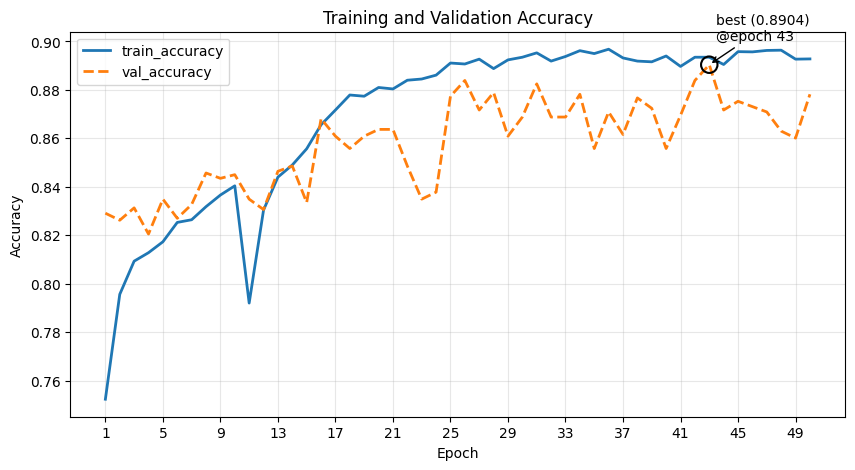

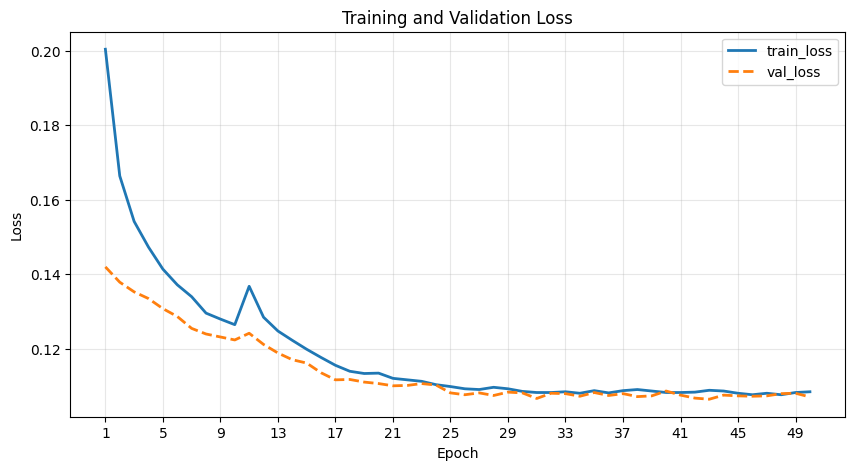

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Optional, Tuple

def linear_fill_missing(xs: Sequence[float]) -> np.ndarray:
    """Linearly interpolate over None/np.nan values in a 1D sequence."""
    arr = np.array([np.nan if (x is None) else x for x in xs], dtype=float)
    n = arr.size
    indices = np.arange(n)
    mask = ~np.isnan(arr)
    if mask.sum() == 0:
        return arr
    # If leading or trailing NaNs exist, fill with nearest non-NaN (so plot won't start/stop abruptly).
    if not mask[0]:
        arr[:np.where(mask)[0][0]] = arr[mask][0]
    if not mask[-1]:
        arr[np.where(mask)[0][-1]+1:] = arr[mask][-1]
    # Interpolate interior NaNs
    mask = ~np.isnan(arr)
    arr[np.isnan(arr)] = np.interp(indices[np.isnan(arr)], indices[mask], arr[mask])
    return arr

def prepare_series(epochs: Sequence[int],
                   series: Sequence[Optional[float]],
                   interpolate: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return x (epochs) and y (values) arrays.
    If interpolate=True, missing values (None or np.nan) are linearly interpolated.
    If interpolate=False, missing values are left as np.nan so matplotlib will show breaks.
    """
    x = np.array(epochs, dtype=int)
    if interpolate:
        y = linear_fill_missing(series)
    else:
        y = np.array([np.nan if (v is None) else v for v in series], dtype=float)
    return x, y

def plot_metrics(epochs: Sequence[int],
                 train_acc: Sequence[Optional[float]],
                 val_acc: Sequence[Optional[float]],
                 train_loss: Sequence[Optional[float]],
                 val_loss: Sequence[Optional[float]],
                 interpolate: bool = True,
                 save_acc_path: Optional[str] = None,
                 save_loss_path: Optional[str] = None,
                 mark_best_on: Optional[str] = None):
    """
    Plot accuracy and loss without point markers.
    - mark_best_on: "val_acc", "val_loss", "train_acc", etc. will mark the best epoch on both plots
      (for losses the "best" is min, for accuracies it's max).
    """
    # Prepare arrays
    x_acc, y_train_acc = prepare_series(epochs, train_acc, interpolate=interpolate)
    _, y_val_acc = prepare_series(epochs, val_acc, interpolate=interpolate)
    x_loss, y_train_loss = prepare_series(epochs, train_loss, interpolate=interpolate)
    _, y_val_loss = prepare_series(epochs, val_loss, interpolate=interpolate)

    # Helper to find best epoch
    best_epoch = None
    if mark_best_on is not None:
        metric_map = {
            "train_acc": (y_train_acc, True),
            "val_acc":   (y_val_acc, True),
            "train_loss":(y_train_loss, False),
            "val_loss":  (y_val_loss, False),
        }
        if mark_best_on in metric_map:
            arr, is_max = metric_map[mark_best_on]
            # Ignore nans
            valid_mask = ~np.isnan(arr)
            if valid_mask.any():
                arr_valid = arr[valid_mask]
                x_valid = x_acc[valid_mask]  # same x_acc used for epochs
                idx = np.argmax(arr_valid) if is_max else np.argmin(arr_valid)
                best_epoch = (int(x_valid[idx]), float(arr_valid[idx]))

    # ---- Plot Accuracy (no markers on the lines) ----
    plt.figure(figsize=(10,5))
    plt.plot(x_acc, y_train_acc, linestyle='-', linewidth=2, label='train_accuracy')
    plt.plot(x_acc, y_val_acc, linestyle='--', linewidth=2, label='val_accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    tick_interval = max(1, len(x_acc)//12)
    plt.xticks(x_acc[::tick_interval])
    plt.grid(alpha=0.3)
    plt.legend()
    if best_epoch and 'acc' in (mark_best_on or ''):
        be, bv = best_epoch
        # keep a visible highlighted marker for the best epoch
        plt.scatter([be], [bv], s=140, edgecolors='k', facecolors='none', linewidths=1.5, zorder=5)
        plt.annotate(f"best ({bv:.4f})\n@epoch {be}", xy=(be,bv), xytext=(be+0.5, bv+0.01),
                     arrowprops=dict(arrowstyle="->", lw=1))
    if save_acc_path:
        plt.savefig(save_acc_path, dpi=150, bbox_inches='tight')
    plt.show()

    # ---- Plot Loss (no markers on the lines) ----
    plt.figure(figsize=(10,5))
    plt.plot(x_loss, y_train_loss, linestyle='-', linewidth=2, label='train_loss')
    plt.plot(x_loss, y_val_loss, linestyle='--', linewidth=2, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    tick_interval = max(1, len(x_loss)//12)
    plt.xticks(x_loss[::tick_interval])
    plt.grid(alpha=0.3)
    plt.legend()
    if best_epoch and 'loss' in (mark_best_on or ''):
        be, bv = best_epoch
        plt.scatter([be], [bv], s=140, edgecolors='k', facecolors='none', linewidths=1.5, zorder=5)
        plt.annotate(f"best ({bv:.4f})\n@epoch {be}", xy=(be,bv), xytext=(be+0.5, bv+0.01),
                     arrowprops=dict(arrowstyle="->", lw=1))
    if save_loss_path:
        plt.savefig(save_loss_path, dpi=150, bbox_inches='tight')
    plt.show()


# -----------------------------
# Example usage (epochs 1..50). Replace these arrays with your data if needed.
if __name__ == "__main__":
    epochs = list(range(1, 51))

    train_acc = [
        0.7523, 0.7956, 0.8093, 0.8128, 0.8173, 0.8253, 0.8264, 0.8318, 0.8366, 0.8404,
        0.7920, 0.8304, 0.8440, 0.8490, 0.8557, 0.8656, 0.8717, 0.8779, 0.8774, 0.8810,
        0.8804, 0.8840, 0.8845, 0.8861, 0.8911, 0.8907, 0.8927, 0.8888, 0.8924, 0.8935,
        0.8953, 0.8919, 0.8938, 0.8962, 0.8950, 0.8968, 0.8932, 0.8919, 0.8916, 0.8940,
        0.8897, 0.8935, 0.8935, 0.8905, 0.8958, 0.8957, 0.8963, 0.8964, 0.8927, 0.8928
    ]

    val_acc = [
        0.8291, 0.8262, 0.8313, 0.8205, 0.8349, 0.8270, 0.8327, 0.8457, 0.8435, 0.8450,
        0.8349, 0.8306, 0.8464, 0.8486, 0.8335, 0.8681, 0.8609, 0.8558, 0.8609, 0.8637,
        0.8637, 0.8486, 0.8349, 0.8378, 0.8774, 0.8839, 0.8717, 0.8789, 0.8609, 0.8688,
        0.8825, 0.8688, 0.8688, 0.8782, 0.8558, 0.8709, 0.8616, 0.8767, 0.8724, 0.8558,
        0.8695, 0.8839, 0.8904, 0.8717, 0.8753, 0.8731, 0.8709, 0.8630, 0.8601, 0.8782
    ]

    train_loss = [
        0.2004, 0.1664, 0.1542, 0.1473, 0.1414, 0.1372, 0.1340, 0.1296, 0.1280, 0.1265,
        0.1368, 0.1285, 0.1248, 0.1223, 0.1199, 0.1177, 0.1156, 0.1140, 0.1134, 0.1135,
        0.1121, 0.1117, 0.1113, 0.1104, 0.1099, 0.1093, 0.1091, 0.1097, 0.1093, 0.1086,
        0.1083, 0.1083, 0.1085, 0.1081, 0.1088, 0.1082, 0.1088, 0.1091, 0.1087, 0.1083,
        0.1083, 0.1084, 0.1089, 0.1087, 0.1081, 0.1077, 0.1081, 0.1077, 0.1083, 0.1085
    ]

    val_loss = [
        0.1420, 0.1379, 0.1353, 0.1335, 0.1308, 0.1287, 0.1255, 0.1240, 0.1232, 0.1224,
        0.1242, 0.1212, 0.1189, 0.1171, 0.1162, 0.1136, 0.1117, 0.1118, 0.1111, 0.1107,
        0.1101, 0.1102, 0.1107, 0.1103, 0.1082, 0.1077, 0.1082, 0.1075, 0.1084, 0.1082,
        0.1067, 0.1081, 0.1080, 0.1073, 0.1083, 0.1075, 0.1080, 0.1072, 0.1074, 0.1087,
        0.1076, 0.1068, 0.1065, 0.1076, 0.1074, 0.1073, 0.1074, 0.1080, 0.1081, 0.1071
    ]

    plot_metrics(
        epochs=epochs,
        train_acc=train_acc,
        val_acc=val_acc,
        train_loss=train_loss,
        val_loss=val_loss,
        interpolate=True,  # no-op here since there are no missing values
        save_acc_path="accuracy_epochs_1_50_no_markers.png",
        save_loss_path="loss_epochs_1_50_no_markers.png",
        mark_best_on="val_acc"
    )


Using existing `model` in globals.
Model expects input size: (224, 224)
Using EfficientNetV2 preprocess for generator.
Found 1389 images belonging to 2 classes.
Collected test images: (1389, 224, 224, 3) labels: (1389,)
Running TTA predictions...
TTA done. Scores length: 1389


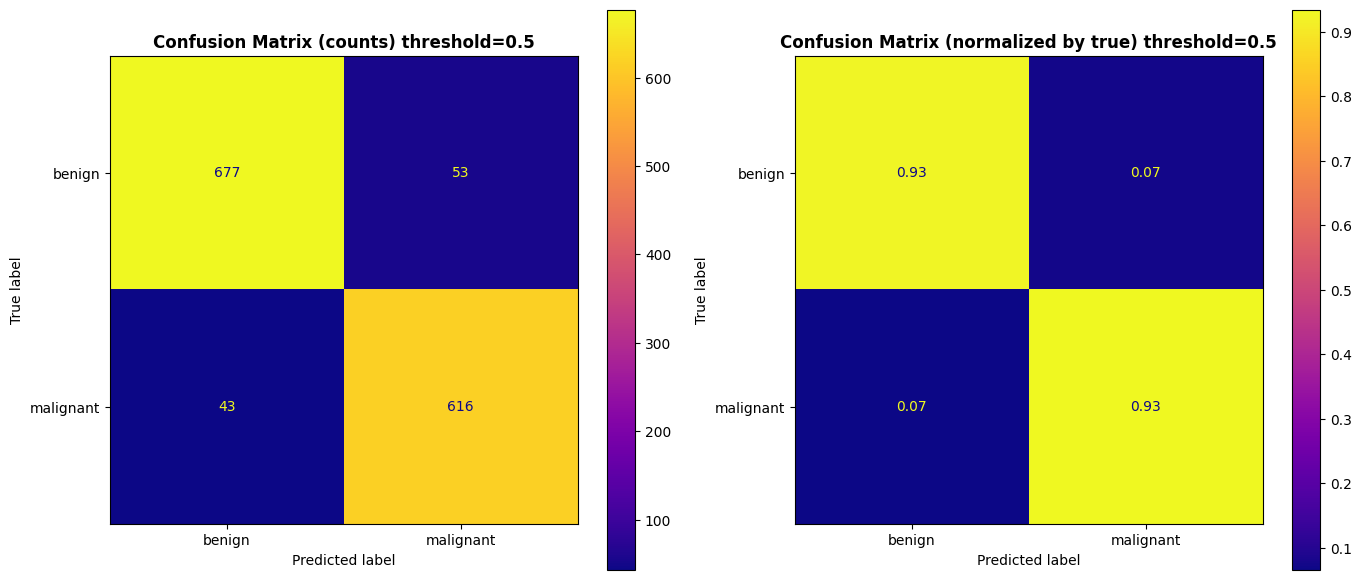

Saved confusion matrix image to: ./cm_outputs/confmat_20251011_102415.png

Accuracy: 0.9309

Classification report:

              precision    recall  f1-score   support

      benign       0.94      0.93      0.93       730
   malignant       0.92      0.93      0.93       659

    accuracy                           0.93      1389
   macro avg       0.93      0.93      0.93      1389
weighted avg       0.93      0.93      0.93      1389



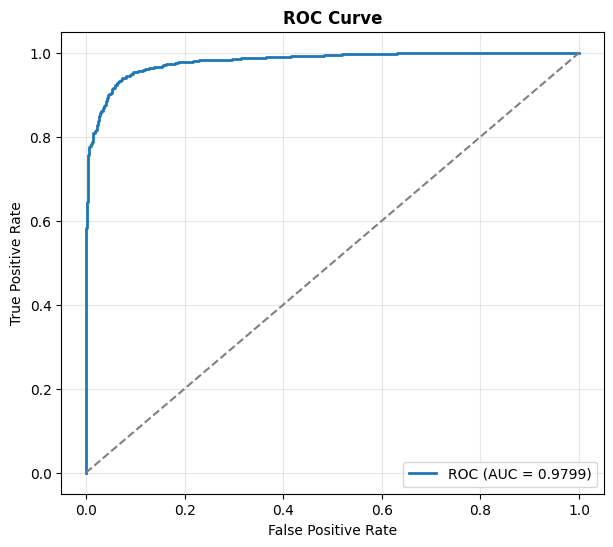

Saved ROC image to: ./cm_outputs/roc_20251011_102416.png


In [ ]:
# Resize-aware TTA + colored confusion matrix + ROC
import os, math, glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------- Settings (adjust only if needed) ----------
SAVE_DIR = "/content/drive/MyDrive/Melanoma_Detection_Models"
TEST_DIR = "split_data/test"   # your test folder with class subfolders
BATCH_SIZE = 24
THRESHOLD = 0.5
CMAP = "plasma"
OUT_DIR = "./cm_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# --------- Helpers (re-define for safety) ----------
def find_best_model_file(save_dir):
    cand = []
    for root, _, files in os.walk(save_dir):
        for f in files:
            if "best" in f.lower() or "efficient" in f.lower() or "eff" in f.lower():
                cand.append(os.path.join(root, f))
    cand = [c for c in cand if os.path.isfile(c)]
    if not cand:
        return None, []
    cand.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return cand[0], cand

def extract_xy_from_generator(gen):
    # Collect all batches from a Keras generator/Sequence that yields (x,y)
    try:
        if hasattr(gen, "reset"):
            gen.reset()
    except Exception:
        pass
    n_samples = getattr(gen, "samples", None)
    batch_size = getattr(gen, "batch_size", None) or getattr(gen, "_batch_size", None) or gen.batch_size
    Xs, ys = [], []
    if n_samples is not None and batch_size is not None:
        n_steps = int(math.ceil(n_samples / batch_size))
        for _ in range(n_steps):
            xb, yb = next(gen)
            Xs.append(np.asarray(xb)); ys.append(np.asarray(yb))
        X = np.vstack(Xs)[:n_samples]; y = np.concatenate(ys)[:n_samples]
    else:
        try:
            while True:
                xb, yb = next(gen)
                Xs.append(np.asarray(xb)); ys.append(np.asarray(yb))
        except StopIteration:
            pass
        if not Xs:
            raise ValueError("Generator returned no data.")
        X = np.vstack(Xs); y = np.concatenate(ys)
    if y.ndim > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)
    return X, y.astype(int)

def to_pos_probs(preds):
    preds = np.asarray(preds)
    if preds.ndim == 1:
        return preds.ravel()
    if preds.ndim == 2:
        if preds.shape[1] == 1:
            return preds[:,0].ravel()
        else:
            return preds[:,1].ravel()
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

# --------- Main ---------
# 1) get model (reuse loaded `model` if present)
if 'model' in globals():
    mdl = globals()['model']
    print("Using existing `model` in globals.")
else:
    model_file = globals().get('model_file', None)
    if model_file is None or not os.path.exists(model_file):
        model_file, cands = find_best_model_file(SAVE_DIR)
        if model_file is None:
            raise FileNotFoundError(f"No candidate model found in {SAVE_DIR}. Set MODEL_EXACT_PATH or save model there.")
        print("Auto-selected model:", model_file)
    else:
        print("Using model_file from globals:", model_file)
    mdl = load_model(model_file, compile=False)
    print("Loaded model:", getattr(model_file, 'name', model_file))

# 2) determine model input spatial size
# model.input_shape typically is (None, H, W, C) for channels-last
input_shape = None
try:
    ms = mdl.input_shape
    if ms is None:
        # fallback to first layer input shape
        ms = mdl.layers[0].input_shape
    input_shape = tuple(ms[1:3])
except Exception:
    raise RuntimeError("Could not determine model input shape. Inspect model.input_shape.")

print("Model expects input size:", input_shape)

# 3) create test generator with matching target size + correct preprocess_input if available
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Test directory not found: {TEST_DIR}. Put your test images in class subfolders there.")

# Prefer EfficientNetV2 preprocess if available (safe for EfficientNet family)
try:
    from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as ef_preprocess
    datagen = ImageDataGenerator(preprocessing_function=ef_preprocess)
    print("Using EfficientNetV2 preprocess for generator.")
except Exception:
    datagen = ImageDataGenerator()
    print("No ef_preprocess available; using raw generator (will NOT preprocess).")

test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=input_shape,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# 4) collect X,y
X_all, y_true = extract_xy_from_generator(test_gen)
print("Collected test images:", X_all.shape, "labels:", y_true.shape)

# NOTE: Since generator used preprocessing_function (ef_preprocess) when created, X_all is already preprocessed.
# If datagen did not apply preprocessing, apply ef_preprocess now if available.
if datagen.preprocessing_function is None:
    try:
        from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as ef_preprocess
        X_pp = ef_preprocess(X_all.copy())
        print("Applied ef_preprocess to X_all.")
    except Exception:
        X_pp = X_all.copy()
        print("No preprocess function applied; using raw images.")
else:
    X_pp = X_all.copy()

# 5) TTA predictions: original, horizontal flip, vertical flip
print("Running TTA predictions...")
p_orig = mdl.predict(X_pp, batch_size=BATCH_SIZE, verbose=0)
p_hf = mdl.predict(X_pp[:, :, ::-1, :], batch_size=BATCH_SIZE, verbose=0)
p_vf = mdl.predict(X_pp[:, ::-1, :, :], batch_size=BATCH_SIZE, verbose=0)

pos1 = to_pos_probs(p_orig)
pos2 = to_pos_probs(p_hf)
pos3 = to_pos_probs(p_vf)
y_score = np.mean([pos1, pos2, pos3], axis=0)
print("TTA done. Scores length:", y_score.shape[0])

# 6) validate lengths
if y_score.shape[0] != y_true.shape[0]:
    raise ValueError(f"Length mismatch: y_score ({y_score.shape[0]}) != y_true ({y_true.shape[0]})")

# 7) compute predictions and confusion matrices
y_pred = (y_score >= THRESHOLD).astype(int)
cm_raw = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

# 8) plot colored confusion matrices side-by-side and save
fig, axes = plt.subplots(1, 2, figsize=(14,6))
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=["benign","malignant"])
disp_raw.plot(cmap=CMAP, ax=axes[0], values_format='d')
axes[0].set_title(f"Confusion Matrix (counts) threshold={THRESHOLD}", fontweight='bold')

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["benign","malignant"])
disp_norm.plot(cmap=CMAP, ax=axes[1], values_format='.2f')
axes[1].set_title(f"Confusion Matrix (normalized by true) threshold={THRESHOLD}", fontweight='bold')

plt.tight_layout()
outpath = os.path.join(OUT_DIR, f"confmat_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
fig.savefig(outpath, dpi=150, bbox_inches='tight')
plt.show()
print("Saved confusion matrix image to:", outpath)

# 9) metrics + ROC
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=["benign","malignant"], zero_division=0))

if len(np.unique(y_true)) >= 2:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve", fontweight='bold')
    plt.legend(loc='lower right')
    roc_path = os.path.join(OUT_DIR, f"roc_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.grid(alpha=0.3)
    plt.savefig(roc_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved ROC image to:", roc_path)
else:
    print("ROC not plotted (single-class in y_true).")

# Done
